# Votre mission

    1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

    2. Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
    
    3. Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

# Imports

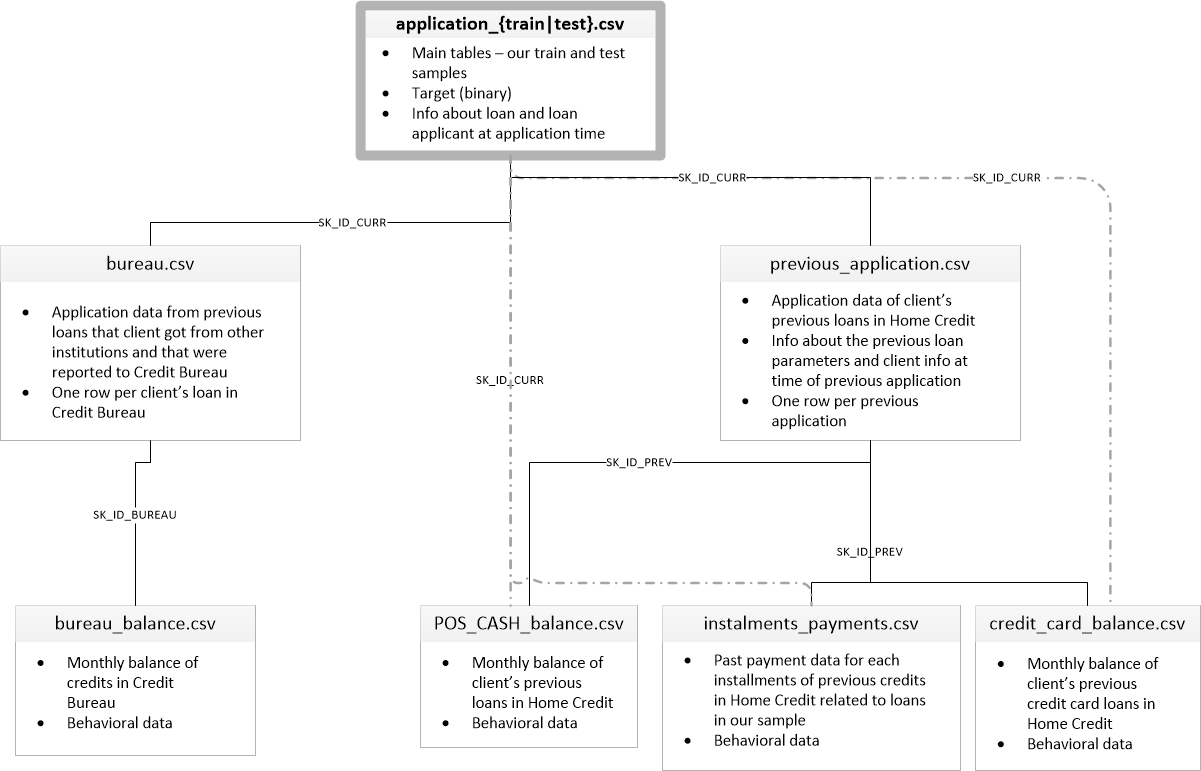

# Model
## Functions

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
import sklearn

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
features = pd.read_csv('./data/application_train.csv')
data = pd.read_csv('./data/application_test.csv')

### Data preparation

In [3]:
def processData(features):
    import pickle
    input1 = open("scaler.pickle", "rb")  # !!! Scaler get from gaggle notbook XXXX
    scaler = pickle.load(input1)
    input1.close()
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR'])  
      
    # OHE
    features = pd.get_dummies(features)   
   
   # Age information into a separate dataframe
    age_data = features[['TARGET', 'DAYS_BIRTH']]
    age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

    # Bin the age data
    age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
    age_data.head(10)
    
    # Bin the age data
    features['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
    
    features['CREDIT_INCOME_PERCENT'] = features['AMT_CREDIT'] / features['AMT_INCOME_TOTAL']
    features['ANNUITY_INCOME_PERCENT'] = features['AMT_ANNUITY'] / features['AMT_INCOME_TOTAL']
    features['CREDIT_TERM'] = features['AMT_ANNUITY'] / features['AMT_CREDIT']
    features['DAYS_EMPLOYED_PERCENT'] = features['DAYS_EMPLOYED'] / features['DAYS_BIRTH']
    
    features.dropna(axis='columns', inplace=True)
    
    from sklearn.preprocessing import MinMaxScaler
    
    return features


In [4]:
features = processData(features)
features

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,CREDIT_INCOME_PERCENT,DAYS_EMPLOYED_PERCENT
0,1,0,202500.0,406597.5,0.018801,-9461,-637,-3648.0,-2120,1,...,0,0,0,0,1,0,1,0,2.007889,0.067329
1,0,0,270000.0,1293502.5,0.003541,-16765,-1188,-1186.0,-291,1,...,0,0,0,0,0,0,1,0,4.790750,0.070862
2,0,0,67500.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,1,...,0,0,0,0,0,0,0,0,2.000000,0.011814
3,0,0,135000.0,312682.5,0.008019,-19005,-3039,-9833.0,-2437,1,...,0,0,0,0,0,0,0,0,2.316167,0.159905
4,0,0,121500.0,513000.0,0.028663,-19932,-3038,-4311.0,-3458,1,...,0,0,0,0,0,0,0,0,4.222222,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,157500.0,254700.0,0.032561,-9327,-236,-8456.0,-1982,1,...,0,0,0,0,1,0,1,0,1.617143,0.025303
307507,0,0,72000.0,269550.0,0.025164,-20775,365243,-4388.0,-4090,1,...,0,0,0,0,1,0,1,0,3.743750,-17.580890
307508,0,0,153000.0,677664.0,0.005002,-14966,-7921,-6737.0,-5150,1,...,0,0,0,1,0,0,1,0,4.429176,0.529266
307509,1,0,171000.0,370107.0,0.005313,-11961,-4786,-2562.0,-931,1,...,0,0,0,0,1,0,1,0,2.164368,0.400134


### Data spliting for train, validation and test

In [5]:
def split_data(x, y, train_ratio = 0.75, validset = True, validation_ratio = 0.15, test_ratio = 0.10):
    from sklearn.model_selection import train_test_split       
    if validset:        
        # train is now 75% of the entire data set
        x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=1 - train_ratio)

        # test is now 10% of the initial data set
        # validation is now 15% of the initial data set
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
        return x_train, x_val, x_test, y_train, y_val, y_test
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=train_ratio)
        return x_train, x_test, y_train, y_test 

In [6]:
x_train, x_test, y_train, y_test = split_data(features.drop(columns=["TARGET"]), y = features.TARGET, validset = False)

### Confusion matrix

In [7]:
def confusion_matrix(model, x_test, y_test, predict = True):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    if predict:  
        y_pred = model.predict(x_test) 
    else:
        y_pred = np.max(model.predict_proba(x_test), axis = 1)
        y_pred = np.where(y_pred > 0.5, 1, 0) 
             
    cm = confusion_matrix(y_test, y_pred)
    #print("Score:" + str(model.best_score_))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

### Custom class 
To allow probabilities calibrations with custum loss function

In [34]:

class Lighboost:
    from sklearn.preprocessing import OneHotEncoder
    # initialization
    def __init__(self, lgbm_func,  params):
        """__init__ Set up your ligthgbm model
        
        Args:
            lgbm_func (function): a ligthgbm model
            params (dict): ligthgbm model parameters
        """
        self.params = params
        self.lgbm_func = lgbm_func
        self.estimator = lgbm_func
        
    # method for fitting the model
    def fit(self, X, y, *args, **kwargs):  
        """fit Fit a lightgbm model 

        Fit the lightgbm model with any additional arguments available in lightgbm models

        Args:
            X (2D array): Predictors
            y (1D array): Outcome 

        Returns:
            _type_: fitted model
        """
        self.lgbm_func = self.lgbm_func(**self.params)
        self.lgbm_func.fit(X, y, *args, **kwargs)
        self.estimator = self.lgbm_func
        return self
    
    def predict_proba_Calibrated(self, X, y, lr_params, num_iteration = 50, *args, **kwargs):
        """predict_proba_Calibrated Calibrate proabbilities
        Args:
            X (2D array): Predictors
            y (1D array): Outcome 
            lr_params (dict): regression model parameters
            num_iteration (int, optional): Number of trees to asses leafes index. Defaults to 50.
            *args, **kwargs are additional arguments for lr.fit
        Returns:
            _type_: Calibrated proabbilities
        """
        from sklearn.preprocessing import OneHotEncoder   
        self.lr_params = lr_params     
        # Apply the model to the data in order to get the leave indexes       
        self.leafindex = self.lgbm_func.predict(X, num_iteration = num_iteration, pred_leaf = True)
        # then, we one-hot encode the leave indexes so we can use them in the logistic regression
        self.encoder = OneHotEncoder()        
        self.leaves_encoded =  self.encoder.fit_transform(self.leafindex)
        
        # we configure the logistic regression and fit it to the encoded leaves
        self.lr = sklearn.linear_model.LogisticRegression(**lr_params)
        self.lr.fit(self.leaves_encoded, y, *args, **kwargs)
        y_hat = self.lr.predict_proba(self.leaves_encoded)
        return y_hat
    
    def predict_proba(self, X):
        y_hat = self.lgbm_func.predict_proba(X)
        return y_hat
    
    def predict(self, X, custom = False, **args):
        if custom:
            y_hat = self.lgbm_func.predict(X, **args)
        else:
            y_hat = 1/(1+np.exp(-self.lgbm_func.predict(X, **args)))
        return y_hat
    
    def get_model(self):
        return self.lgbm_func #return a ligthgbm
    
    def score(self, X, y, score_func, lr_params = None, prob = True, calibrated = True,  num_iteration = 50,*args, **kwargs):
        if prob:
            if calibrated:
                pred = self.predict_proba_Calibrated(X, y, lr_params, num_iteration = 50,*args, **kwargs)
            else:
                pred = self.predict_proba(X)
        else:
            pred = self.predict(X)
            
        score = score_func(y, pred)    
        return score
    
    # get_params, needed for sklearn estimators
    def get_params(self, deep=True):
        return {'params': self.params,
                'lr_params': self.lr_params,
                'lgbm_func': self.lgbm_func,
                'estimator': self.lgbm_func}
        

## Bayesien optyimization

In [9]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold

In [10]:
X = np.array(x_train)
y = np.array(y_train)

In [11]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OneHotEncoder

def custom_lgbm_function2(lgbm_func, score_fun, n_folds, params, search_space, X, y, 
                         lr_params, calibrate = True, *args, **kwargs):
    
    # Function for Bayesian Optimization--------------------------------------------
    def folds_scores(**hyperparams):
        scores = []
        kf = KFold(n_splits=(n_folds))
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
            
            # Split the data into train and validation sets for this fold
            X_fold_train, y_fold_train = X[train_idx], y[train_idx]
            X_fold_val, y_fold_val = X[val_idx], y[val_idx]
            train_set = lgb.Dataset(X_fold_train, label=y_fold_train)
            
            # Train a LightGBM model with the specified hyperparameters
            hyperparams = {**params, **hyperparams}  # Merge the search space and initial hyperparameters    
            hyperparams["num_leaves"] = int(hyperparams["num_leaves"]) # Force integers      
            hyperparams["n_estimators"] = int(hyperparams["n_estimators"]) # Force integers        
        
            model = Lighboost(lgbm_func, params = hyperparams)
            model.fit(X_fold_val, y_fold_val, *args, **kwargs)
            
            if calibrate:  
                y_pred_calibrated = model.predict_proba_Calibrated(X_fold_val, y_fold_val, lr_params) [:,1]
                val_loss_calibrated = score_fun(y_fold_val, y_pred_calibrated)    
                val_loss = -val_loss_calibrated

            else:
                val_loss = score_fun(y_fold_val, model.predict_proba(X_fold_val))  
                val_loss = -val_loss          

                
            scores.append(val_loss)
        return np.mean(np.array(scores))

    # Run Bayesian Optimization  -----------------------------
    optimizer = BayesianOptimization(f=folds_scores, pbounds=search_space, random_state=42)
    optimizer.maximize(init_points=5, n_iter=20)
    
    # Get best hyperparams-----------------------------
    result = max(optimizer.res, key=lambda x:x['target'])    
    tmp = result
    del tmp["target"]
    tmp["params"]["num_leaves"] = int(tmp["params"]["num_leaves"]) # Force integers      
    tmp["params"]["n_estimators"] = int(tmp["params"]["n_estimators"]) # Force integers 
    hyperparams = {**params, **tmp["params"]} 

    train_set = lgb.Dataset(X, label=y)  
    model = Lighboost(lgbm_func, params = hyperparams)
    model.fit(X, y, *args, **kwargs)
    return model

In [34]:
params = {
    'objective': "binary",
    'is_unbalance': True,
    'verbose': -1
}

search_space = {
    'learning_rate': (0.7, 0.8),
    'num_leaves': (10, 10.01),
    'n_estimators': (100, 500)
}

lr_params = {'solver':'sag',
             'C': 0.001354,
             'fit_intercept': False, 
             'class_weight': "balanced"
             }

models = custom_lgbm_function2(lgb.LGBMClassifier, score_fun = log_loss, n_folds=2, params=params, 
                              search_space=search_space, X = X, y = y, 
                              lr_params = lr_params, calibrate = True)

|   iter    |  target   | learni... | n_esti... | num_le... |
-------------------------------------------------------------
| 1         | -0.641    | 0.7375    | 480.3     | 10.01     |
| 2         | -0.6511   | 0.7599    | 162.4     | 10.0      |
| 3         | -0.6346   | 0.7058    | 446.5     | 10.01     |
| 4         | -0.649    | 0.7708    | 108.2     | 10.01     |
| 5         | -0.6489   | 0.7832    | 184.9     | 10.0      |
| 6         | -0.6498   | 0.7612    | 391.5     | 10.01     |
| 7         | -0.6355   | 0.7129    | 447.3     | 10.0      |
| 8         | -0.653    | 0.778     | 436.5     | 10.0      |
| 9         | -0.6485   | 0.7509    | 473.6     | 10.0      |
| 10        | -0.649    | 0.8       | 443.3     | 10.0      |
| 11        | -0.6341   | 0.7018    | 450.1     | 10.01     |
| 12        | -0.631    | 0.7071    | 452.5     | 10.01     |
| 13        | -0.6532   | 0.7995    | 455.6     | 10.0      |
| 14        | -0.6491   | 0.7407    | 451.4     | 10.0      |
| 15    

In [80]:
models.predict_proba(X)

array([[0.86095017, 0.13904983],
       [0.61925966, 0.38074034],
       [0.72033851, 0.27966149],
       ...,
       [0.61422717, 0.38577283],
       [0.9193636 , 0.0806364 ],
       [0.64489522, 0.35510478]])

In [35]:
models.predict(X, num_iteration = 50, pred_leaf = True)

array([[7, 6, 7, ..., 4, 0, 0],
       [8, 4, 6, ..., 6, 0, 0],
       [5, 5, 7, ..., 4, 0, 0],
       ...,
       [5, 5, 7, ..., 4, 0, 0],
       [8, 4, 6, ..., 3, 0, 0],
       [5, 5, 7, ..., 6, 0, 0]])

In [36]:
y_train= np.array(y_train)
x_train = np.array(x_train)

# MLFLOW

In [12]:

import mlflow
import mlflow.lightgbm
from urllib.parse import urlparse

def mlflow_track_model(lgbm_func, score_fun, n_folds, params, search_space, X, y, X_test, y_test, calibrate = True, 
                       weigthed = False, custom_score = True, custom_logloss = True, sklearn_metric = sklearn.metrics.roc_auc_score,
                       name = "model", registered_model_name ="myModel", *args, **kwargs):    
    
    """mlflow_track_model _summary_

    MLOPs if MLFLOW and custom lightgbm function that allow any ligthGbm algorithm, folds, custom metrics, custom log-loss, Bayesian optimization and Probabilities calibration.

    Arguments:
        lgbm_func {lightgbm function} -- lightgbm algorithm
        score_fun {score function} -- any score that compare prediction and y_test
        n_folds {int} -- Number of folds
        params {dict} -- lightgbm params
        search_space {dict} -- search space for Bayesian optimization 
        X {2D array} -- Predictors to train on
        y {1D array} -- target  to train on
        X_test {2D array} --  Predictors to test on
        y_test {1D array} -- Target to test on
        sklearn_metric  {sklearn.metric function}  -- sklearn_metric for comparaison with score_fun
        *args, **kwargs additional arguments for custom_lgbm_function2 function
        
    Keyword Arguments:
        calibrate {bool} -- Perform calibration (default: {True})
        calibrate_method {str} -- CalibratedClassifierCV methods for calibration  (default: {'sigmoid'})
        weigthed {bool} -- account for unbalance calsess (default: {False})
        custom_score {bool} -- is a custom score is used ? (default: {True})
        custom_logloss {bool} -- is a custom loss function is used ? (default: {True})
        name {str} -- MLFLOW model name (default: {"model"})
        registered_model_name {str} --  MLFLOW registered model name  (default: {"myModel"})
    """
    
    with mlflow.start_run() as run:
        if weigthed:
            w = {'class_weight': None}
            params = {**params, **w}
        model = custom_lgbm_function2(lgbm_func, score_fun, n_folds, params, search_space, X, y, 
                                       calibrate = True, *args, **kwargs)

        mlflow.log_param("Calibrated", calibrate)
        mlflow.log_param("custom_loss", custom_logloss)
        mlflow.log_param("custom_score", custom_score)        
        mlflow.log_param("weigthed", weigthed)
       
        if custom_score:
            if calibrate:
                prob = model.predict_proba_Calibrated(X_test, y_test, lr_params= lr_params)[:,1]
                prob = np.where(prob > 0.5, 1, 0)
                mlflow.log_metric("score_value", score_fun(y_test, prob))
                mlflow.log_metric("sklearn_metric", sklearn_metric(y_test, prob))
            else:
                mlflow.log_metric("score_value", score_fun(y_test, model.predict(X_test)))
                mlflow.log_metric("sklearn_metric",sklearn_metric(y_test, model.predict(X_test)))
        else:
            mlflow.log_metric("score_value", np.nan)
            mlflow.log_metric("sklearn_metric", sklearn_metric(y_test, model.predict(X_test)))                         
               
       
        metrics = model.params
        for key in metrics:
            if str(metrics[key]).isnumeric():
                mlflow.log_metric(key, metrics[key])
            else:
                mlflow.log_param(key, metrics[key])
        

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.lightgbm.log_model(model, name, registered_model_name=registered_model_name)
        else:
            mlflow.lightgbm.log_model(model, name) 
    mlflow.end_run()

In [32]:
search_space = {
    'learning_rate': (0.7, 0.8),
    'num_leaves': (10, 10.01),
    'n_estimators': (100, 500)
}

lr_params = {'solver':'sag',
             'C': 0.001354,
             'fit_intercept': False,
            'class_weight': 'balanced'
             }

params = {
    'objective': "binary",
    'verbose': -1
}

mlflow_track_model(lgb.LGBMClassifier, score_fun = log_loss, n_folds=10, 
                   params=params, lr_params = lr_params, search_space = search_space, 
                   X = X, y = y, X_test = x_test, y_test = y_test, sklearn_metric = sklearn.metrics.roc_auc_score,
                   weigthed = False, calibrate = False, custom_score = False, custom_logloss = False,
                   name = "Model0", registered_model_name = "Model0")

params = {
    'objective': "binary",
    'is_unbalance': True,
    'verbose': -1
}


mlflow_track_model(lgb.LGBMClassifier, score_fun = log_loss, n_folds=10, 
                   params=params, lr_params = lr_params, search_space = search_space, 
                   X = X, y = y, X_test = x_test, y_test = y_test, sklearn_metric = sklearn.metrics.roc_auc_score,
                   weigthed = True, calibrate = False, custom_score = False, custom_logloss = False,
                   name = "Model1", registered_model_name = "Model1")

mlflow_track_model(lgb.LGBMClassifier, score_fun = log_loss, n_folds=10, 
                   params=params, lr_params = lr_params, search_space = search_space, 
                   X = X, y = y, X_test = x_test, y_test = y_test, sklearn_metric = sklearn.metrics.roc_auc_score,
                   weigthed = True, calibrate = True, custom_score = False, custom_logloss = False,
                   name = "Model2", registered_model_name = "Model2")

### Custom score

In [13]:
def logreg_err_beta(y_true, predt, beta = 0.2):
    predt = np.array(predt)
    y_true = np.array(y_true)
    '''Custom evaluation metric that should be in line with custom loss function'''
    predt=np.clip(predt,10e-7,1-10e-7)
    loss_fn=y_true*np.log(predt)
    loss_fp=(1.0-y_true)*np.log(1.0-predt)
    return np.sum(-(loss_fn+beta*loss_fp))/len(y)


In [23]:

mlflow_track_model(lgb.LGBMClassifier, score_fun = logreg_err_beta, n_folds=10, 
                   params=params, lr_params = lr_params, search_space = search_space, 
                   X = X, y = y, X_test = x_test, y_test = y_test, sklearn_metric = sklearn.metrics.roc_auc_score,
                   weigthed = True,  calibrate = True, custom_score = True, custom_logloss = False,
                   name = "Model3", registered_model_name = "Model3")


|   iter    |  target   | learni... | n_esti... | num_le... |
-------------------------------------------------------------
| 1         | -0.01664  | 0.7375    | 480.3     | 10.01     |
| 2         | -0.01694  | 0.7599    | 162.4     | 10.0      |
| 3         | -0.01626  | 0.7058    | 446.5     | 10.01     |
| 4         | -0.01691  | 0.7708    | 108.2     | 10.01     |
| 5         | -0.01689  | 0.7832    | 184.9     | 10.0      |
| 6         | -0.0168   | 0.745     | 410.7     | 10.0      |
| 7         | -0.01691  | 0.7871    | 445.6     | 10.01     |
| 8         | -0.01672  | 0.7325    | 291.6     | 10.0      |
| 9         | -0.01688  | 0.7943    | 247.2     | 10.0      |
| 10        | -0.01689  | 0.7894    | 444.6     | 10.0      |
| 11        | -0.01669  | 0.7332    | 372.0     | 10.01     |
| 12        | -0.01631  | 0.7094    | 420.5     | 10.01     |
| 13        | -0.01678  | 0.7403    | 436.3     | 10.01     |
| 14        | -0.01692  | 0.761     | 188.6     | 10.01     |
| 15    

## Custom loss function

In [22]:
def first_grad_logreg_beta(y_true, predt, beta = 4):
    '''Compute the first derivative for custom logloss function'''
    return predt*(beta-beta*y_true+y_true)-y_true

def second_grad_logreg_beta(y_true, predt, beta = 4):
    '''Compute the second derivative for custom logloss function'''
    predt = np.array(predt)
    return (y_true+beta-beta*y_true)*predt*(1-predt)


def CustomLoss(y, p, k = 0, alpha = 1, beta = 0.4):
    grad = ( - y*alpha / (p+k) + beta*(1-y) / (1-p+k) ) * dpdx
    hess = ( alpha*y / (p+k)**2 + beta*(1-y) / (1-p+k)**2 ) * dpdx**2 \
        + ( - y*alpha / (p+k) + beta*(1-y) / (1-p+k) ) * ddpddx

def logregobj_beta(y_true, predt):
    
    beta = 1
    predt = np.array(predt)
    predt = 1/(1+np.exp(-predt))
    y_true = np.array(y_true)
    beta = np.array(beta)
    
    '''Custom logloss function update'''
    grad=first_grad_logreg_beta(predt,y_true, beta = beta)
    hess=second_grad_logreg_beta(predt,y_true, beta = beta)
    
    return grad, hess

In [29]:
def custom_loss_function(y, pred) :
    """
    gradian and hessian computation for loss function defined by :
    L(y,x) = - alpha * y * ln(p(x) + k) - beta * (1 - y) * ln(1-p(x) + k)

    PS : y takes values in {0,1}
    PPS : for k = 0; alpha = 1; beta = 1 the definition corresponds to log loss
    """
    k = 0 # score of other model
    alpha = 1; beta = 0.4
    p = (1 / (1 + np.exp(-pred)))
    dpdx = np.exp(-pred) * p**2
    ddpddx = -np.exp(-pred) * p**2 + np.exp(-pred) * 2 * p * dpdx
    grad = ( - y*alpha / (p+k) + beta*(1-y) / (1-p+k) ) * dpdx
    hess = ( alpha*y / (p+k)**2 + beta*(1-y) / (1-p+k)**2 ) * dpdx**2 \
        + ( - y*alpha / (p+k) + beta*(1-y) / (1-p+k) ) * ddpddx
    return grad, hess


In [33]:
custom_loss_function(np.array([0,1,0]), np.array([0,1,0]))

(array([ 0.2       , -0.26894142,  0.2       ]),
 array([0.1       , 0.19661193, 0.1       ]))

In [35]:
m = Lighboost(lgb.LGBMClassifier,params = {
    'objective': custom_loss_function,
    'verbose': -1
})
m.fit(X,y)

In [39]:
np.unique(m.predict(X))

array([0.0133754 , 0.01464789, 0.01483805, ..., 0.69634196, 0.71766457,
       0.79240023])

In [40]:
m.predict(X, num_iteration = 50, pred_leaf = True)

array([[0.95257413, 0.99999996, 1.        , ..., 1.        , 0.9999833 ,
        1.        ],
       [0.99966465, 0.99966465, 0.99987661, ..., 0.5       , 0.73105858,
        1.        ],
       [0.95257413, 0.99999996, 1.        , ..., 1.        , 0.73105858,
        0.5       ],
       ...,
       [0.73105858, 1.        , 0.73105858, ..., 0.99999917, 0.99752738,
        1.        ],
       [0.88079708, 1.        , 0.88079708, ..., 1.        , 0.88079708,
        0.5       ],
       [0.99999996, 1.        , 0.99987661, ..., 0.5       , 0.73105858,
        0.5       ]])

In [43]:
m.predict_proba_Calibrated(X, y, lr_params = lr_params, num_iteration = 50)

array([[0.68035083, 0.31964917],
       [0.55140594, 0.44859406],
       [0.67089216, 0.32910784],
       ...,
       [0.31309011, 0.68690989],
       [0.73365101, 0.26634899],
       [0.42905437, 0.57094563]])

In [ ]:
params = {
    'objective': logregobj_beta,
    'verbose': -1
}
mlflow_track_model(lgb.LGBMClassifier, score_fun = logreg_err_beta, n_folds=10, params=params, 
    search_space = search_space, X = X, y = y, X_test = x_test, y_test = y_test, sklearn_metric = sklearn.metrics.roc_auc_score,
    lr_params = lr_params, calibrate = True,
    weigthed = True, custom_score = True, custom_logloss = True,
    name = "Model4", registered_model_name = "Model4")



# Visualization

In [56]:
#####################################
##### Model Visualization
#####################################
import shap
def modelVisualization(m, X_test, select = range(20)):
    explainer = shap.TreeExplainer(m.estimator)   

    #P1
    import warnings
    expected_value = explainer.expected_value
    if isinstance(expected_value, list):
        expected_value = expected_value
    print(f"Explainer expected value: {expected_value}")
    
    features = X_test.iloc[select]
    features = np.array(features)
    features_display = X_test.columns

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        shap_values = explainer.shap_values(features)[1]
        shap_interaction_values = explainer.shap_interaction_values(features)
    if isinstance(shap_interaction_values, list):
        shap_interaction_values = shap_interaction_values[1]
    shap.decision_plot(expected_value, shap_values, features_display)       

Explainer expected value: [-1.25808377]
(20, 185)


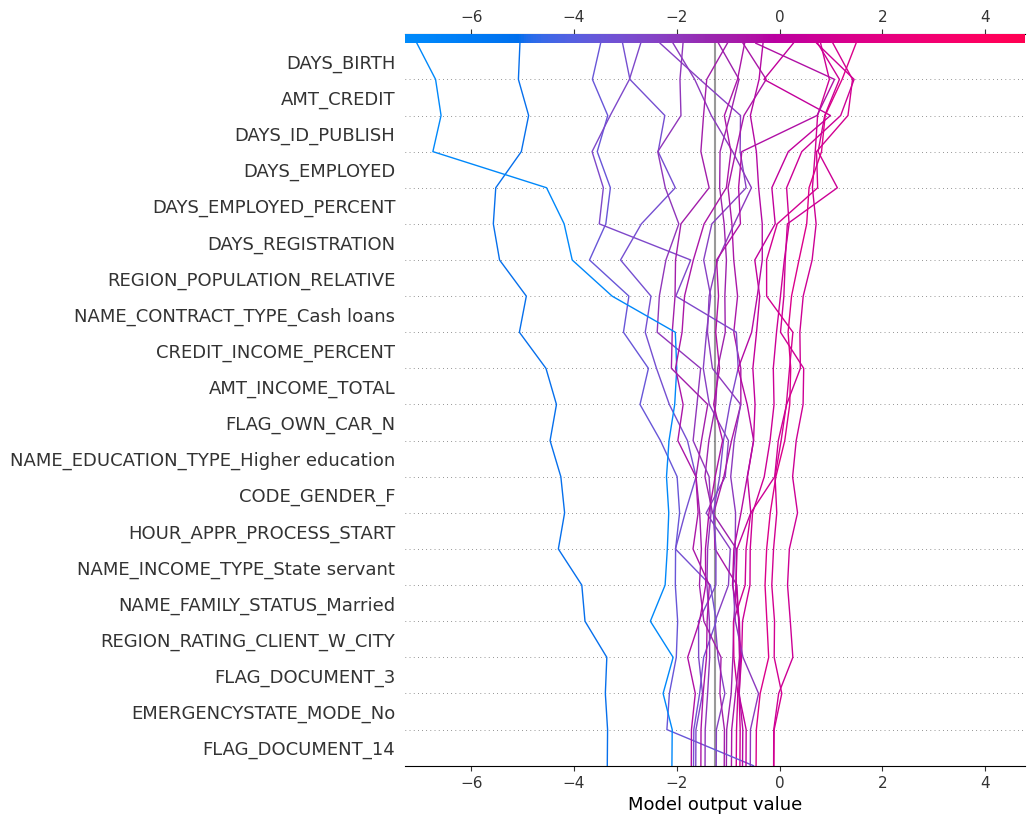

In [57]:
modelVisualization(models, features.drop(columns=["TARGET"], axis = 1))

# Building API
## Sauvegarde des outils

In [15]:
# Same function as previously but without target
def processData2(features):
    import pickle
    input1 = open("scaler.pickle", "rb")
    scaler = pickle.load(input1)
    input1.close()
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR'])  
      
    # OHE
    features = pd.get_dummies(features)   
   
   # Age information into a separate dataframe
    age_data = features[['DAYS_BIRTH']]
    age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

    # Bin the age data
    age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
    age_data.head(10)
    # Bin the age data
    features['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
    
    features['CREDIT_INCOME_PERCENT'] = features['AMT_CREDIT'] / features['AMT_INCOME_TOTAL']
    features['ANNUITY_INCOME_PERCENT'] = features['AMT_ANNUITY'] / features['AMT_INCOME_TOTAL']
    features['CREDIT_TERM'] = features['AMT_ANNUITY'] / features['AMT_CREDIT']
    features['DAYS_EMPLOYED_PERCENT'] = features['DAYS_EMPLOYED'] / features['DAYS_BIRTH']
    
    features.dropna(axis='columns', inplace=True)
    
    from sklearn.preprocessing import MinMaxScaler
    # Transform both training and testing data
    #features = imputer.transform(features)    
    # Repeat with the scaler
    #features = scaler.transform(features)  
  
    # Convert to np arrays
    #features = np.array(features)
    
    return features
data2 = pd.read_csv('data/application_test.csv')
data2 = processData2(data2)

data2.to_csv("dataReady.csv", index = False)
data2 = np.array(data2)
np.save("dataReadyMat.csv", data2)

From GUI MLFLOW we can see that model 3 (d:/OneDrive/Travail/Formation/formation/6/mlruns/0/30ce4814443448afa014887bea8d6c72/artifacts/Model3/model.pkl) is th best so it it saved on the api 